# How to Perform Cross-DAAC S3 Bucket Access Using Python
### Author: Chris Battisto
### Date Authored: 10-02-22

### Timing

Exercise: 20 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>This notebook <em><strong>will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook demonstrates how to access cloud-hosted GES DISC granules using the [Commmon Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), from two different DAACs ([GES DISC](disc.gsfc.nasa.gov) and [PO.DAAC](https://podaac.jpl.nasa.gov/)).
It then plots these two variables at a single time step.

### Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files: 
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Xarray
- S3FS
- Boto3
- NumPy
- Matplotlib
- Cartopy



### Import Libraries

In [1]:
import requests
import xarray as xr
import s3fs
import numpy as np
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import boto3
from IPython.display import display, Markdown

%matplotlib inline

### Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

### Retrieve Granule S3 Links

First, for [M2T1NXSLV](https://search.earthdata.nasa.gov/search/granules?p=C1276812863-GES_DISC&pg[0][v]=f&pg[0][gsk]=-start_date&q=m2t1nxslv&ff=Available%20from%20AWS%20Cloud&fdc=Goddard%20Earth%20Sciences%20Data%20and%20Information%20Services%20Center%20(GES%20DISC)&tl=1658766017!3!!&lat=-0.140625&long=0.0703125):

In [3]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

merra_response = requests.get(cmr_url, 
                                params={
                                    'concept_id': 'C1276812863-GES_DISC',
                                    'temporal': '2012-10-25T00:00:00Z',
                                    'page_size': 200,
                                    },
                                headers={
                                    'Accept': 'application/json'
                                    }
                               )

# Parse out links from the JSON response:

print('First granule S3 URL:') 
pprint.pprint(merra_response.json()['feed']['entry'][0]['links'][1])
print('S3 Token Endpoint:')
pprint.pprint(merra_response.json()['feed']['entry'][0]['links'][3])

First granule S3 URL:
{'href': 's3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2012/10/MERRA2_400.tavg1_2d_slv_Nx.20121025.nc4',
 'hreflang': 'en-US',
 'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
 'title': 'This link provides direct download access via S3 to the granule'}
S3 Token Endpoint:
{'href': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
 'hreflang': 'en-US',
 'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
 'title': 'api endpoint to retrieve temporary credentials valid for '
          'same-region direct s3 access (VIEW RELATED INFORMATION)'}


Then, for [GHRSST](https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1?ids=&values=&provider=POCLOUD#):

In [4]:
ghrsst_response = requests.get(cmr_url, 
                                params={
                                    'concept_id': 'C1996881146-POCLOUD',
                                    'temporal': '2012-10-25T00:00:00Z',
                                    'page_size': 200,
                                    },
                                headers={
                                    'Accept': 'application/json'
                                    }
                               )

print('First granule S3 URL:') 
pprint.pprint(ghrsst_response.json()['feed']['entry'][0]['links'][0])
print('S3 Token Endpoint:')
pprint.pprint(ghrsst_response.json()['feed']['entry'][0]['links'][4])

First granule S3 URL:
{'href': 's3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20121025090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'hreflang': 'en-US',
 'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
 'title': 'This link provides direct download access via S3 to the granule.'}
S3 Token Endpoint:
{'href': 'https://archive.podaac.earthdata.nasa.gov/s3credentials',
 'hreflang': 'en-US',
 'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
 'title': 'api endpoint to retrieve temporary credentials valid for '
          'same-region direct s3 access'}


### Obtain S3 Credentials and Open Bucket Granules

In [5]:
# Define a function for S3 access credentials

def begin_s3_direct_access(daac_url):
    response = requests.get(daac_url).json()
    
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})


In [6]:
# Get tokens from GES DISC and PODAAC:

gesdisc_s3 = merra_response.json()['feed']['entry'][0]['links'][3]['href']
podaac_s3 = ghrsst_response.json()['feed']['entry'][0]['links'][4]['href']

# Open S3 file systems with S3FS

gesdisc_fs = begin_s3_direct_access(gesdisc_s3)
podaac_fs = begin_s3_direct_access(podaac_s3)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file

type(gesdisc_fs)
type(podaac_fs)

s3fs.core.S3FileSystem

### Open Granules in Xarray

In [6]:
# Create filesets
merra_fn = merra_response.json()['feed']['entry'][0]['links'][1]['href']

ghrsst_fn = ghrsst_response.json()['feed']['entry'][0]['links'][0]['href']

# Open datasets with S3FS
merra_ds = xr.open_dataset(gesdisc_fs.open(merra_fn))
ghrsst_ds = xr.open_dataset(podaac_fs.open(ghrsst_fn))

Clip to extent over where the hurricane was:

In [7]:
min_lon = -89
min_lat = 14
max_lon = -67
max_lat = 31

merra_ds = merra_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
ghrsst_ds = ghrsst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

### Convert Dataset Grids

First, we need to interpolate the GHRSST grid to the MERRA grid using Xarray.

In [8]:
ghrsst_ds = ghrsst_ds.interp(lat=merra_ds.lat, lon=merra_ds.lon)

In [9]:
ghrsst_ds

<xarray.Dataset>
Dimensions:           (lat: 35, lon: 35, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2012-10-25T09:00:00
  * lat               (lat) float64 14.0 14.5 15.0 15.5 ... 29.5 30.0 30.5 31.0
  * lon               (lon) float64 -88.75 -88.12 -87.5 ... -68.75 -68.12 -67.5
Data variables:
    analysed_sst      (time, lat, lon) float64 nan nan nan ... 300.0 299.4 299.4
    analysis_error    (time, lat, lon) float64 nan nan nan ... 0.37 0.37 0.37
    mask              (time, lat, lon) float64 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0
    sea_ice_fraction  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Plot Variables using Matplotlib

Text(0.5, 0.95, 'GHRSST Analyzed SST and MERRA-2 2M Wind Streamlines on 2012-10-25T00:00:00Z')

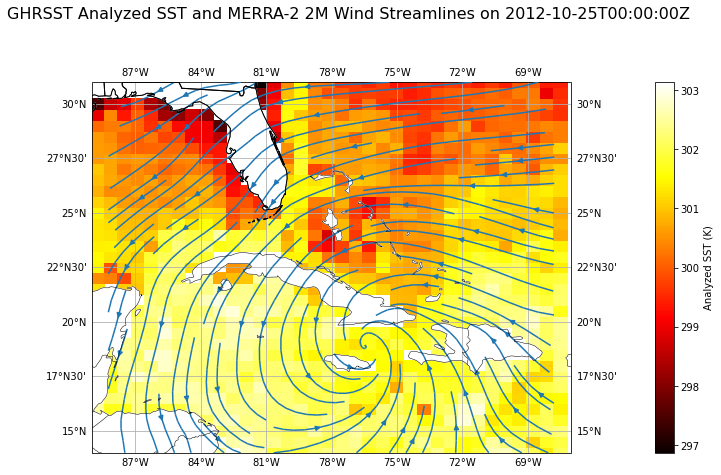

In [10]:
# Pre-configure streamplot vectors

u=merra_ds.U2M
v=merra_ds.V2M
lon=merra_ds.lon
lat=merra_ds.lat

lons, lats = np.meshgrid(lon, lat)

# Plotting routines

plt.rcParams['figure.figsize'] = 15, 15

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-89, -67, 14, 31], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, zorder=5) 
ax.add_feature(cfeature.LAND, facecolor='white', zorder=1) 
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
ax.add_feature(cfeature.STATES, zorder=5)

mmp = ax.pcolormesh(lons, lats, ghrsst_ds.analysed_sst.isel(time=0), 
              cmap='hot', transform=ccrs.PlateCarree(), zorder=1)
    
ax.streamplot(lons, lats, u.isel(time=0).values, v.isel(time=0).values, zorder=4, transform=ccrs.PlateCarree())

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = plt.colorbar(mmp, pad=0.1)
cbar.set_label("Analyzed SST (K)")

fig.suptitle("GHRSST Analyzed SST and MERRA-2 2M Wind Streamlines on 2012-10-25T00:00:00Z", size=16, y=0.95)